In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ppg=pd.read_csv("CMU_resample.csv")

In [3]:
ppg.head()

,CustomerID,invoice_count,total_products,avg_purchase_frequency,avg_spend_ttm,label
0,15185,1,666,0.000000,31.062,0
1,17131,5,983,0.526316,246.317,0
2,16475,4,319,6.851852,54.430,0
3,13854,29,2278,3.159292,802.502,0
4,14741,6,841,6.224138,140.034,0


In [4]:
ppg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              1700 non-null   int64  
 1   invoice_count           1700 non-null   int64  
 2   total_products          1700 non-null   int64  
 3   avg_purchase_frequency  1700 non-null   float64
 4   avg_spend_ttm           1700 non-null   float64
 5   label                   1700 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 79.8 KB


# EDA

## Churn rate

Text(0.5, 1.0, 'Churn rate')

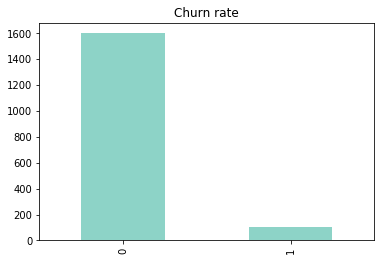

In [5]:
ppg.label.value_counts().plot(kind='bar',colormap="Set3")
plt.title("Churn rate")

In [6]:
ppg.label.value_counts()/1700*100

0    94.117647
1     5.882353
Name: label, dtype: float64

The dataset is an imbalanced dataset. We have to deal with it while doing further analysis.

## Invoice count

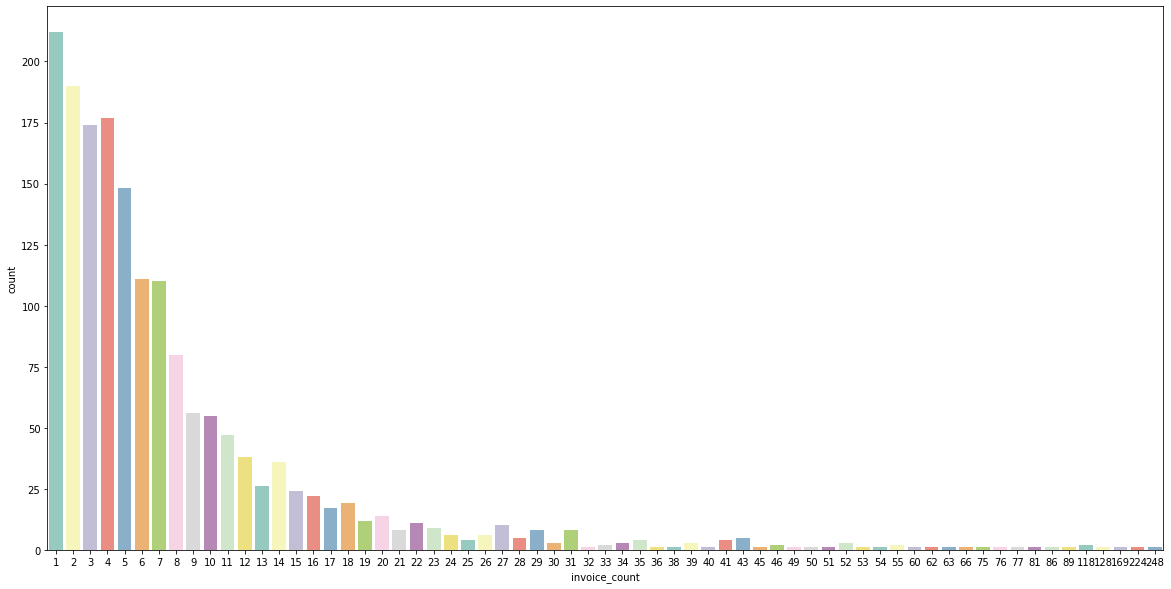

In [7]:
plt.figure(figsize=(20,10))
sns.countplot('invoice_count', data=ppg, palette="Set3")

In [8]:
ppg.invoice_count.value_counts()

1      212
2      190
4      177
3      174
5      148
      ... 
45       1
40       1
38       1
36       1
248      1
Name: invoice_count, Length: 65, dtype: int64

In [9]:
avr_product_per_invoice=ppg.total_products/ppg.invoice_count
ppg.insert(5, "avr_product_per_invoice", avr_product_per_invoice, True) 

In [10]:
ppg.avr_product_per_invoice=ppg.avr_product_per_invoice.round(0)

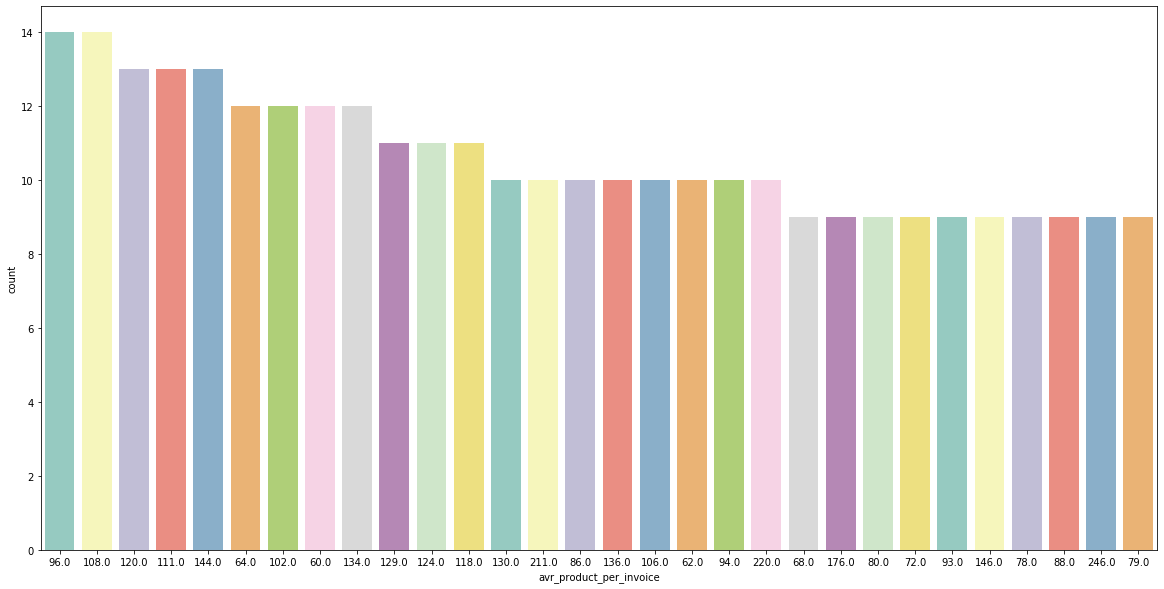

In [11]:
plt.figure(figsize=(20,10))
sns.countplot('avr_product_per_invoice',data=ppg, order=ppg.avr_product_per_invoice.value_counts().iloc[:30].index,palette="Set3")

## Decision Tree

In [12]:
import imblearn
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn import metrics

In [13]:
#split dataset in features and target variable
feature_cols = ["invoice_count", "total_products", "avg_purchase_frequency", "avg_spend_ttm"]
X = ppg[feature_cols] # Features
y = ppg.label # Target variable

In [14]:
X

,invoice_count,total_products,avg_purchase_frequency,avg_spend_ttm
0,1,666,0.000000,31.062
1,5,983,0.526316,246.317
2,4,319,6.851852,54.430
3,29,2278,3.159292,802.502
4,6,841,6.224138,140.034
...,...,...,...,...
1695,5,1167,1.852632,143.885
1696,3,971,1.779661,254.372
1697,4,480,0.715909,73.950
1698,3,103,21.800000,14.905


### Data Balancing via SMOTE

In [15]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [16]:
from imblearn.over_sampling import SMOTE #Over sampling
import numpy as np

## Instantiate smote and balance training data only
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)

## Compute and print percentage of high quality wine after balancing
print('Percentage of high quality counts in the balanced data:{}%'.format(np.sum(y_res==1)/len(y_res)*100))

Percentage of high quality counts in the balanced data:50.0%


### Model Fitting

In [17]:
## Instantiate random forest and train on balanced training data
model = DecisionTreeClassifier()
model.fit(X_res, y_res)
y_pred_res=model.predict(X_test)

test_acc = accuracy_score(y_test, y_pred_res)

print('Decision tree classifier accuray:', test_acc)

test_recall = recall_score(y_test, y_pred_res)

print('Decision tree classifier recall:', test_recall)

Decision tree classifier accuray: 0.8274509803921568
Decision tree classifier recall: 0.4117647058823529


Text(0.5, 0, 'False Positive Rate')

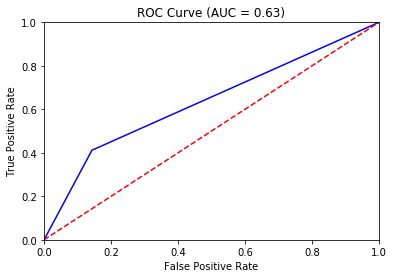

In [31]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_res)
plt.title("ROC Curve (AUC = %0.2f)"% metrics.roc_auc_score(y_test, y_pred_res))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [19]:
# AUC-ROC
auROC = metrics.roc_auc_score(y_test,y_pred_res)
print('AUC-ROC of the learned Decision Tree classifier: {}'.format(auROC))

AUC-ROC of the learned Decision Tree classifier: 0.634453781512605


### Grid Search

In [57]:
from sklearn.model_selection import GridSearchCV
# param_grid = {'max_depth': np.arange(3, 10), }

params = {'criterion': ["gini", "entropy"], 'max_leaf_nodes': list(range(50, 100)), 'max_depth': np.arange(3, 10)}

model_GS = GridSearchCV(DecisionTreeClassifier(), params)

model_GS .fit(X_res, y_res)
tree_preds = model_GS.predict(X_test)
tree_performance = metrics.roc_auc_score(y_test, tree_preds)

test_new_acc = accuracy_score(y_test, tree_preds)

print('Decision tree classifier accuray:', test_new_acc)

test_new_recall = recall_score(y_test, tree_preds)

print('Decision tree classifier recall:', test_new_recall)

print ('DecisionTree: Area under the ROC curve = {}'.format(tree_performance))

Decision tree classifier accuray: 0.7235294117647059
Decision tree classifier recall: 0.47058823529411764
DecisionTree: Area under the ROC curve = 0.60609243697479


In [58]:
model_GS.best_params_

{'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 83}

Text(0.5, 0, 'False Positive Rate')

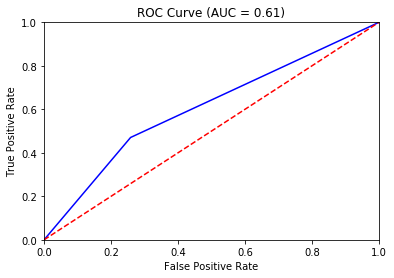

In [59]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, tree_preds)
plt.title("ROC Curve (AUC = %0.2f)"% metrics.roc_auc_score(y_test, tree_preds))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')